# Variational AutoEncoder Generator Tensorflow
This should open a pre-trained VAE and become a Data generator

#### References:
* http://kvfrans.com/variational-autoencoders-explained/
* https://github.com/kvfrans/variational-autoencoder
* https://github.com/int8/VAE_tensorflow
* http://int8.io/variational-autoencoder-in-tensorflow/
* http://blog.fastforwardlabs.com/2016/08/22/under-the-hood-of-the-variational-autoencoder-in.html
* http://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
* https://arxiv.org/pdf/1606.05908.pdf
* https://arxiv.org/pdf/1312.6114.pdf
* http://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
* https://www.tensorflow.org/get_started/embedding_viz
* https://www.youtube.com/watch?v=eBbEDRsCmv4
* https://www.youtube.com/watch?v=bbOFvxbMIV0
* https://www.youtube.com/watch?v=P78QYjWh5sM
* https://github.com/normanheckscher/mnist-tensorboard-embeddings
* http://projector.tensorflow.org/
* https://www.slideshare.net/ShaiHarel/variational-autoencoder-talk

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pylab import *
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
MODEL='/home/leoara01/work/Variational_AutoEncoder/src/notebooks/tensorflow/save/model-1102'
LATENT_SIZE=400
VARIANCE = 1

In [2]:
from models import VAE_Segnet_Generator
model = VAE_Segnet_Generator(latent_size = LATENT_SIZE)
model_in = model.input
model_out = model.output

In [3]:
# Select only the convs
list_convs_linear = [v for v in tf.global_variables() if "z_matrix" in v.name or "conv" in v.name]
list_batch = [v for v in tf.global_variables() if "Batch" in v.name]
#list_params = [v for v in tf.global_variables() if "z_matrix" in v.name or "conv" in v.name]

### Create Dictionary for matching stuff on the checkpoint
#### References
* https://www.tensorflow.org/api_docs/python/tf/train/Saver
* https://stackoverflow.com/questions/39740871/how-to-save-a-dictionary-of-variables-in-tensorflow-using-the-saver-object

In [4]:
dict_saver_match = {}
for items in list_convs_linear:
    addr_on_checkpoint = items.name.split(':')[0]
    addr_on_local_graph = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=items.name)[0]
    dict_saver_match[addr_on_checkpoint] = addr_on_local_graph    

cnt = 7
cnt_item = 1
for items in list_batch:
    # Get the address on the file (starting at 7)
    orig_addr = items.name.split(':')[0].split('/') 
    bn_name_split = orig_addr[0].split('_')
    # Detect first BatchNorm
    is_first = len(bn_name_split) == 1
    if is_first:
        #BatchNorm ===> BatchNorm_7
        batch_addr = orig_addr[0]+'_'+str(cnt)
        #print(batch_addr)
    else:
        #batch_addr = orig_addr[0]+'_'+str(cnt)
        bn_name_split[1] = str(cnt)
        batch_addr = '_'.join(bn_name_split)
        #print(batch_addr)
    
    # Address on local graph
    addr_on_local_graph = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=items.name)[0]
    orig_addr[0] = batch_addr
    #print('/'.join(orig_addr))
    
    # Append corrections to the dictionary
    dict_saver_match['/'.join(orig_addr)] = addr_on_local_graph    
    
    # Update counter each 4 elements
    if (cnt_item % 4) == 0:
        cnt = cnt + 1
    cnt_item = cnt_item + 1

# Problem inside the model the Batchnorm variables are BatchNorm_[1...7] but on the file 
# they are BatchNorm_7...13

#list_params[0].name.split(':')[0]

### Define saver objects to load the VAE generator variables

In [5]:
# Define the saver object to load only the conv variables
#saver_load_autoencoder = tf.train.Saver(var_list=list_params)
saver_load_autoencoder = tf.train.Saver(var_list=dict_saver_match)

### Build Graph and create session

In [6]:
init = tf.global_variables_initializer()

# Avoid allocating the whole memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

#sess = tf.Session()
sess.run(init)

# Initialize all random variables (Weights/Bias)
sess.run(tf.global_variables_initializer())

# Restore only the weights (From AutoEncoder)
saver_load_autoencoder.restore(sess, MODEL)

INFO:tensorflow:Restoring parameters from /home/leoara01/work/Variational_AutoEncoder/src/notebooks/tensorflow/save/model-1102


### Generate some input from the latent space

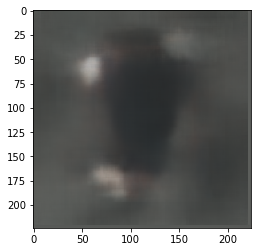

In [7]:
# Create a latent as a normal distribution with size 20, mean 0, variance 1
latent = np.random.normal(0, VARIANCE, [1,LATENT_SIZE])

#latent = np.ones([1,20])
#latent[0,1:10] = -1

out_img = sess.run(model_out, feed_dict={model_in:latent})
plt.imshow(out_img.reshape([224,224,3]))
plt.show()

### Generate a video

In [8]:
dpi = 50

def ani_frame(filename):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(np.random.rand(224,224),cmap='gray',interpolation='nearest')
    #latent = np.random.normal(0, 1, [1,20])
    #out_img = sess.run(model_out, feed_dict={model_in:latent})
    #im = ax.imshow(out_img.reshape([28,28]),cmap='gray',interpolation='nearest')
    
    im.set_clim([0,1])
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        #tmp = rand(300,300)
        #im.set_data(tmp)
        latent = np.random.normal(0, VARIANCE, [1,LATENT_SIZE])
        out_img = sess.run(model_out, feed_dict={model_in:latent})
        im.set_data(out_img.reshape([224,224,3]))
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,300,interval=30)
    writer = animation.writers['ffmpeg'](fps=30)

    ani.save(filename,writer=writer,dpi=dpi)
    return ani

In [9]:
ani_frame('demo_Ped.mp4')